In [3]:
from manim import *
from numpy import linalg as npl
import math
import matplotlib.pyplot as plt
import jupyter_capture_output
from scipy.interpolate import make_interp_spline, BSpline
from multiprocessing import Process

video_scene = " -v WARNING --progress_bar None --disable_caching magnus_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s magnus_Scene"

Manim Community v0.16.0.post0

Jupyter Capture Output v0.0.8


In [83]:
# globale Konstanten
g = 9.81
omega = -0.75               # Winkelgeschwindigkeit
m = 0.02                   # Masse
A_eff = 0.25               # effektvive Fläche des Objektes
rho = 1                 # Dichte des Mediums
c_W = 0.025
R = 1                 

# Systemparameter
C_R = c_W / 2 * rho * A_eff / m
C_M = 2 * R * rho * A_eff / m


# Functions for numerical Integration
def ODE_Magnus(t, y_array, f_array, params):
    v_x = y_array[2]
    v_y = y_array[3]

    f_array[0] = v_x
    f_array[1] = v_y
    f_array[2] = -params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_x - params['C_M'] * omega * v_y
    f_array[3] = -g - params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_y + params['C_M'] * omega * v_x
    return


def rk4_step(t, delta_t, y_array, ode, params):
    k1 = np.zeros_like(y_array)
    k2 = np.zeros_like(y_array)
    k3 = np.zeros_like(y_array)
    k4 = np.zeros_like(y_array)
    support = np.zeros_like(y_array)
    ode(t, y_array, k1, params) 

    # Berechnung k1 = f(t, y) * dt und support = y + k1/2
    k1 *= delta_t
    support = y_array + k1 / 2

    # Berechnung k2 = f(t+dt/2, y+k1/2) * dt und support = y + k2/2
    ode(t+delta_t/2, support, k2, params)
    k2 *= delta_t
    support = y_array + k2 / 2

    # Berechnung k3 = f(t+dt/2, y+k2/2) * dt und support = y + k3
    ode(t+delta_t/2, support, k3, params)
    k3 *= delta_t
    support = y_array + k3

    # Berechnung k4 = f(t+dt, y+k2) * dt und y_(i+1)
    ode(t+delta_t, support, k4, params)
    k4 *= delta_t
    y_array += (k1 + 2*k2 + 2*k3 + k4) / 6; 
    return


# Erzeugung der Daten
t = 0
T_max = 5
N = int(10e3)
delta_t = T_max / N

state_0 = np.array([-3.5, 1.5, 50, -20], float)
param_dick = {'C_R': C_R, 'C_M': C_M}

state_array = np.zeros((N, 4))
state_array[0,:] = state_0
for i in range(1, N):
    t += delta_t
    rk4_step(t, delta_t, state_0, ODE_Magnus, param_dick)
    state_array[i,:] = state_0

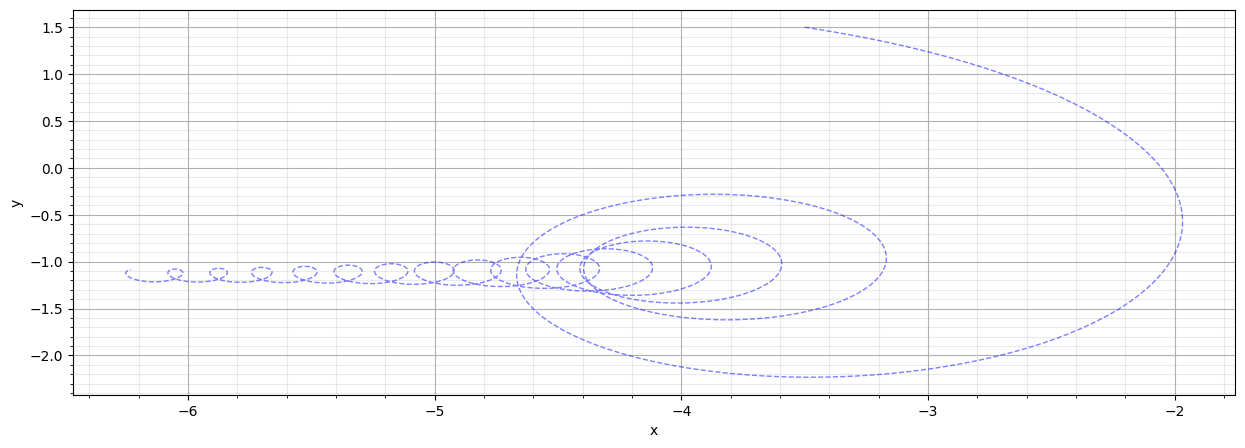

In [84]:
# Darstellung Trajektorie in Matplotlib
fig, ax = plt.subplots(figsize=(15,5))

ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.plot(state_array[:,0], state_array[:,1], color = 'blue', alpha = 0.5, linestyle = '--', linewidth = 1)#, label = f'Runge-Kutta 2')

# ax.legend()
# ax.legend(loc="upper left")

plt.show()

In [85]:
# Beschleunigungen aus Zustandsarray
def a_x(v_x, v_y):
    return -C_R * np.sqrt(v_x**2 + v_y**2) * v_x - C_M * omega * v_y

def a_y(v_x, v_y):
    return -g - C_R * np.sqrt(v_x**2 + v_y**2) * v_y + C_M * omega * v_x

In [93]:
%%capture_video --path "animations/magnus/magnus.mp4"
%%manim -qm --fps 60 $video_scene

class magnus_Scene(Scene):
    def construct(self):
        self.camera.background_color=WHITE
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = BLACK, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)

        # Object
        cylinder_circ = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
        cylinder_line1 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
        cylinder_line2 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
        cylinder_line3 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
        cylinder_line4 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)

        # Linear Start
        dt_lin = 0.05
        x_0_lin = np.linspace(state_array[0, 0] - state_array[0, 2] * dt_lin, state_array[0,0], int(dt_lin / delta_t))
        y_0_lin = np.linspace(state_array[0, 1] - state_array[0, 3] * dt_lin, state_array[0,1], int(dt_lin / delta_t))

        v_x_0_lin = np.linspace(state_array[0, 2], state_array[0, 2], int(dt_lin / delta_t))
        v_y_0_lin = np.linspace(state_array[0, 3], state_array[0, 3], int(dt_lin / delta_t))

        cylinder_group = VGroup(cylinder_circ, cylinder_line1, cylinder_line2, cylinder_line3, cylinder_line4).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = PI/8)
        print(x_0_lin[0], y_0_lin[0])
        cylinder_group.generate_target()
        cylinder_group.target.move_to([state_array[0,0], state_array[0,1], 0])


        # Water
        left_border = -6
        bottom_border = -3
        right_border = 1
        top_border = 1.5

        left_line = Line([left_border, bottom_border, 0], [left_border, top_border + 0.5, 0], color = BLUE)
        right_line = Line([right_border, bottom_border, 0], [right_border, top_border + 0.5, 0], color = BLUE)
        bottom_line = Line([left_border, bottom_border, 0], [right_border, bottom_border, 0], color = BLUE)

        water = Polygon([left_border, bottom_border, 0], [left_border, top_border, 0], [right_border, top_border, 0], [right_border, bottom_border, 0], color = BLUE, fill_opacity = 0.2)

        water_group = VGroup(left_line, right_line, bottom_line, water)


        # Ramp
        ramp_line1 = Line([-6, 3, 0], [-2, 1, 0], color = BLACK)
        ramp_line2 = Line([-6, 3-0.1, 0], [-2, 1-0.1, 0], color = BLACK)
        ramp_group = VGroup(ramp_line1, ramp_line2)
        

        self.add(water_group, cylinder_group)


        # Geschwindigkeit
        v_factor = 25
        x_i = state_array[0,0]
        y_i = state_array[0,1]
        v_x_i = state_array[0,2] / v_factor
        v_y_i = state_array[0,3] / v_factor
        v_vector = Line([x_i, y_i, 0], [x_i + v_x_i, y_i + v_y_i, 0], color = BLACK, stroke_width = 2).add_tip(tip_length = 0.15, tip_width = 0.1)

        # Magnuskraft
        magnus_vector = Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m, y_i + a_y(v_x_i, v_y_i) * m, 0], color = DARK_BLUE, stroke_width = 2).add_tip(tip_length = 0.15, tip_width = 0.1)

        # Erzeugung der Iter
        x_cylinder_iter = iter(np.append(x_0_lin, state_array[:,0], axis = 0))
        y_cylinder_iter = iter(np.append(y_0_lin, state_array[:,1], axis = 0))

        v_x_cylinder_iter = iter(np.append(v_x_0_lin, state_array[:,2] / v_factor, axis = 0))
        v_y_cylinder_iter = iter(np.append(v_y_0_lin, state_array[:,3] / v_factor, axis = 0))

        
        # Zylinder-Updater
        def cylinder_lin_move_updater(cylinder):
            x_i = next(x_cylinder_iter)
            y_i = next(y_cylinder_iter)
            v_x_i = next(v_x_cylinder_iter)
            v_y_i = next(v_y_cylinder_iter)
            cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)

        def cylinder_move_updater(cylinder):
            x_i = next(x_cylinder_iter)
            y_i = next(y_cylinder_iter)
            v_x_i = next(v_x_cylinder_iter)
            v_y_i = next(v_y_cylinder_iter)
            cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
            v_vector.become(Line([x_i, y_i, 0], [x_i + v_x_i, y_i + v_y_i, 0], color = BLACK, stroke_width = 2).add_tip(tip_length = 0.15, tip_width = 0.1))
            magnus_vector.become(Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m, y_i + a_y(v_x_i, v_y_i) * m, 0], color = DARK_BLUE, stroke_width = 2).add_tip(tip_length = 0.15, tip_width = 0.1))



        self.add(cylinder_group)
        #self.play(FadeIn(cylinder_group))
        self.wait(1.5)
        time = ValueTracker(0)
        cylinder_group.add_updater(cylinder_lin_move_updater)
        self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
        cylinder_group.remove_updater(cylinder_lin_move_updater)
        self.play(FadeIn(v_vector), FadeIn(magnus_vector), run_time = 1.5)
        self.wait(2)
        cylinder_group.add_updater(cylinder_move_updater)
        self.play(time.animate.set_value(5), rate_func= linear, run_time = 20)
        self.wait(2)

Output saved by overwring previous file at animations/magnus/magnus.mp4.
-6.0 2.5
